In [67]:
# Removes large-scale background gradients from the input flc files

from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma, SigmaClip, sigma_clip
import glob
import numpy as np
from photutils import Background2D, detect_sources, detect_threshold, MedianBackground

################################# USER INPUTS #################################

# The files to remove the background gradient from
files = glob.glob('./test_feb2021_orig_code/*flc.fits')

# The box size to use when creating the 2D background image
box_size = (128, 128)

# Option to mask sources when finding the background gradient
mask_sources = True

###############################################################################

for f in files:
    basename = os.path.basename(f)
    print('Working on {}:'.format(basename))
    h = fits.open(f)
    for ext in [1,4]:
        print('\tWorking on extension {}:'.format(ext))
        data_orig = np.copy(h[ext].data)
        data = h[ext].data

        # Subtract off median
        clipped = sigma_clip(data, sigma=3, maxiters=5)
        data = data - np.nanmedian(clipped)

        # Find sources in the gradient-removed image
        if mask_sources:
            print('\tMaking source segmap...')
            s = SigmaClip(sigma=3.)
            bkg_estimator = MedianBackground()
            bkg = Background2D(data, box_size=box_size, filter_size=(10, 10), 
                               sigma_clip=s, bkg_estimator=bkg_estimator)
            skydark = bkg.background
            data_flat = data_orig - skydark
            threshold = detect_threshold(data_flat, nsigma=1.0)
            sigma = 3.0 * gaussian_fwhm_to_sigma
            kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
            kernel.normalize()
            segm = detect_sources(data_flat, threshold, npixels=5, filter_kernel=kernel)
            segmap = segm.data
            fits.writeto(f.replace('_flc.fits', '_segmap_ext{}.fits'.format(ext)), 
                         segmap, overwrite=True)
        else:
            segmap = np.zeros(data.shape).astype(int)
        
        # Find the background gradient, incorporating the source mask
        print('\tFinding the background gradient...')
        s = SigmaClip(sigma=3.)
        bkg_estimator = MedianBackground()
        mask = (segmap > 0)
        bkg = Background2D(data, box_size=box_size, filter_size=(10, 10), 
                           sigma_clip=s, bkg_estimator=bkg_estimator, mask=mask)
        skydark = bkg.background
        fits.writeto(f.replace('_flc.fits', '_bkg_ext{}.fits'.format(ext)), 
                     skydark, overwrite=True)

        # Subtract the background gradient from the original image
        data_new = data_orig - skydark
        h[ext].data = data_new.astype('float32')

    h.writeto(f, overwrite=True)
    h.close()
    print('Finished removing background gradient from {}'.format(basename))


Working on jdxfa9i0q_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9i0q_flc.fits
Working on jdxfa9iaq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9iaq_flc.fits
Working on jdxfa9hoq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9hoq_flc.fits
Working on jdxfa9ikq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9ikq_flc.fits
Working on jdxfa9i7q_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9i7q_flc.fits
Working on jdxfa9isq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9isq_flc.fits
Working on jdxfa9ihq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9ihq_flc.fits
Working on jdxfa9ieq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9ieq_flc.fits
Working on jdxfa9inq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9inq_flc.fits
Working on jdxfa9hrq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9hrq_flc.fits
Working on jdxfa9hxq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9hxq_flc.fits
Working on jdxfa9iqq_flc.fits:
	Working on extension 1:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
	Working on extension 4:


/Users/bsunnquist/miniconda3/envs/astroconda2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


	Making source segmap...
	Finding the background gradient...
Finished removing background gradient from jdxfa9iqq_flc.fits


In [144]:
# Removes large-scale background gradients from the input flc files, and equalizes the overall
# background levels between chips

from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma, SigmaClip, sigma_clip
import glob
import numpy as np
from photutils import Background2D, detect_sources, detect_threshold, MedianBackground


################################# USER INPUTS #################################

# The files to correct
files = glob.glob('./test_feb2021_new_code/*flc.fits')

# The box size to use when creating the 2D background image
box_size = (128, 128)

# Option to mask sources when finding the background gradient/pedestal level
mask_sources = True

###############################################################################


# STEP 1: Remove the large-scale 2D background gradient from each chip
print('STEP 1: Removing 2D gradients from input FLCs...')
for f in files:
    basename = os.path.basename(f)
    print('Working on {}:'.format(basename))
    h = fits.open(f)
    for ext in [1,4]:
        print('\tWorking on extension {}:'.format(ext))
        data_orig = np.copy(h[ext].data)
        data = h[ext].data

        # Subtract off median
        clipped = sigma_clip(data, sigma=3, maxiters=5)
        data = data - np.nanmedian(clipped.data[clipped.mask==False])

        # Find sources in the gradient-removed image
        if mask_sources:
            print('\tMaking source segmap...')
            s = SigmaClip(sigma=3.)
            bkg_estimator = MedianBackground()
            bkg = Background2D(data, box_size=box_size, filter_size=(10, 10), 
                               sigma_clip=s, bkg_estimator=bkg_estimator)
            skydark = bkg.background          
            data_flat = data_orig - skydark
            threshold = detect_threshold(data_flat, nsigma=1.0)
            sigma = 3.0 * gaussian_fwhm_to_sigma
            kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
            kernel.normalize()
            segm = detect_sources(data_flat, threshold, npixels=5, filter_kernel=kernel)
            segmap = segm.data
            fits.writeto(f.replace('_flc.fits', '_segmap_ext{}.fits'.format(ext)), 
                         segmap, overwrite=True)
        else:
            segmap = np.zeros(data.shape).astype(int)
        
        # Find the background gradient, incorporating the source mask
        print('\tFinding the background gradient...')
        s = SigmaClip(sigma=3.)
        bkg_estimator = MedianBackground()
        mask = (segmap > 0)
        bkg = Background2D(data, box_size=box_size, filter_size=(10, 10), 
                           sigma_clip=s, bkg_estimator=bkg_estimator, mask=mask)
        skydark = bkg.background
        fits.writeto(f.replace('_flc.fits', '_bkg_ext{}.fits'.format(ext)), 
                     skydark, overwrite=True)

        # Subtract the background gradient from the original image
        data_new = data_orig - skydark
        h[ext].data = data_new.astype('float32')

    h.writeto(f, overwrite=True)
    h.close()
    print('Finished removing background gradient from {}'.format(basename))


# STEP 2: equalize the overall background/pedestal level between chips to the average of the two chips
print('\nSTEP 2: Equalizing overall backgroud levels in the input FLCs...')
for f in files:
    basename = os.path.basename(f)
    print('Working on {}:'.format(basename))
    h = fits.open(f)
    
    # Find the overall background levels in each chip
    background_levels = []
    for ext in [1,4]:
        data = np.copy(h[ext].data)
        
        # Mask sources using the previous segmap
        if mask_sources:
            segmap = fits.getdata(f.replace('_flc.fits', '_segmap_ext{}.fits'.format(ext)))
        else:
            segmap = np.zeros(data.shape).astype(int)
        data[segmap > 0] = np.nan
        
        # Calculate the background level in the chip
        clipped = sigma_clip(data, sigma=3, maxiters=5)
        background_levels.append(np.nanmedian(clipped.data[clipped.mask==False]))
        print('\tBackground in ext {} = {}'.format(ext, np.nanmedian(clipped.data[clipped.mask==False])))
    
    # Equalize the background levels of the two chips to the average of the two
    avg_bkg = np.mean(background_levels)
    
    ext1_orig = np.copy(h[1].data)
    ext1_diff = background_levels[0] - avg_bkg
    ext1_new = ext1_orig - ext1_diff
    h[1].data = ext1_new.astype('float32')
    
    ext4_orig = np.copy(h[4].data)
    ext4_diff = background_levels[1] - avg_bkg
    ext4_new = ext4_orig - ext4_diff
    h[4].data = ext4_new.astype('float32')
    
    # Write out the final calibrated file
    h.writeto(f, overwrite=True)
    h.close()
    print('Finished equalizing background levels between chips in {}'.format(basename))


STEP 1: Removing 2D gradients from input FLCs...
Working on jdxfa9i0q_flc.fits:
	Working on extension 1:
	Making source segmap...
	Finding the background gradient...
6.640625
	Working on extension 4:
	Making source segmap...
	Finding the background gradient...
10.7421875
Finished removing background gradient from jdxfa9i0q_flc.fits
Working on jdxfa9iaq_flc.fits:
	Working on extension 1:
	Making source segmap...
	Finding the background gradient...
11.9140625
	Working on extension 4:
	Making source segmap...
	Finding the background gradient...
12.109375
Finished removing background gradient from jdxfa9iaq_flc.fits
Working on jdxfa9hoq_flc.fits:
	Working on extension 1:
	Making source segmap...
	Finding the background gradient...
15.0390625
	Working on extension 4:
	Making source segmap...
	Finding the background gradient...
12.109375
Finished removing background gradient from jdxfa9hoq_flc.fits
Working on jdxfa9ikq_flc.fits:
	Working on extension 1:
	Making source segmap...
	Finding the 

	Background in ext 1 = 71.18621826171875


	Background in ext 4 = 70.67459869384766
Finished equalizing background levels between chips in jdxfa9i0q_flc.fits
Working on jdxfa9iaq_flc.fits:


	Background in ext 1 = 17.140623092651367


	Background in ext 4 = 16.849233627319336
Finished equalizing background levels between chips in jdxfa9iaq_flc.fits
Working on jdxfa9hoq_flc.fits:


	Background in ext 1 = 13.538457870483398


	Background in ext 4 = 13.334980010986328
Finished equalizing background levels between chips in jdxfa9hoq_flc.fits
Working on jdxfa9ikq_flc.fits:


	Background in ext 1 = 62.536705017089844


	Background in ext 4 = 61.62502670288086
Finished equalizing background levels between chips in jdxfa9ikq_flc.fits
Working on jdxfa9i7q_flc.fits:


	Background in ext 1 = 35.406715393066406


	Background in ext 4 = 34.96311950683594
Finished equalizing background levels between chips in jdxfa9i7q_flc.fits
Working on jdxfa9isq_flc.fits:


	Background in ext 1 = 30.7147216796875


	Background in ext 4 = 30.376317977905273
Finished equalizing background levels between chips in jdxfa9isq_flc.fits
Working on jdxfa9ihq_flc.fits:


	Background in ext 1 = 9.686750411987305


	Background in ext 4 = 9.644527435302734
Finished equalizing background levels between chips in jdxfa9ihq_flc.fits
Working on jdxfa9ieq_flc.fits:


	Background in ext 1 = 9.95506477355957


	Background in ext 4 = 9.83364486694336
Finished equalizing background levels between chips in jdxfa9ieq_flc.fits
Working on jdxfa9inq_flc.fits:


	Background in ext 1 = 227.0721435546875


	Background in ext 4 = 217.93313598632812
Finished equalizing background levels between chips in jdxfa9inq_flc.fits
Working on jdxfa9hrq_flc.fits:


	Background in ext 1 = 12.116034507751465


	Background in ext 4 = 11.948600769042969
Finished equalizing background levels between chips in jdxfa9hrq_flc.fits
Working on jdxfa9hxq_flc.fits:


	Background in ext 1 = 260.81134033203125


	Background in ext 4 = 252.19610595703125
Finished equalizing background levels between chips in jdxfa9hxq_flc.fits
Working on jdxfa9iqq_flc.fits:


	Background in ext 1 = 43.47593688964844


	Background in ext 4 = 42.94551086425781
Finished equalizing background levels between chips in jdxfa9iqq_flc.fits


In [135]:
mesh = bkg.mesh_nmasked
len(mesh[mesh.mask==True]) / 512 * 100

13.671875

In [126]:
for f in glob.glob('./*a9*flc.fits'):
    print(f)
    print(np.median(fits.getdata(f,1)))

./jdxfa9i0q_flc.fits
71.613525
./jdxfa9iaq_flc.fits
17.363825
./jdxfa9hoq_flc.fits
13.707466
./jdxfa9ikq_flc.fits
63.209267
./jdxfa9i7q_flc.fits
35.688866
./jdxfa9isq_flc.fits
30.954384
./jdxfa9ihq_flc.fits
9.823201
./jdxfa9ieq_flc.fits
10.132814
./jdxfa9inq_flc.fits
228.12245
./jdxfa9hrq_flc.fits
12.226781
./jdxfa9hxq_flc.fits
261.86084
./jdxfa9iqq_flc.fits
43.820576


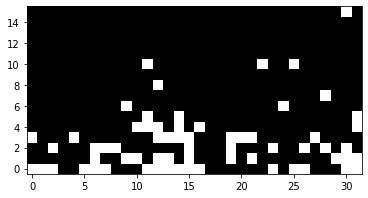

In [147]:
plt.imshow(mesh.mask, origin='lower', cmap='gray')

In [122]:
d = fits.getdata('./jdxfa9iqq_flc.fits',1)
np.nanmedian(d)

43.820576

In [146]:
f

'./test_feb2021_new_code/jdxfa9iqq_flc.fits'

In [117]:
mesh.shape

(16, 32)

In [118]:
16*32

512

In [88]:
252.19610595703125 - ((260.81134033203125+252.19610595703125)/2)

-4.3076171875

In [89]:
d = fits.getdata('./test_feb2021_new_code/jdxfa9hxq_flc.fits', 4)
dd = fits.getdata('./MAST_flcs/jdxfa9hxq_flc.fits', 4)
bkg = fits.getdata('./test_feb2021_new_code/jdxfa9hxq_bkg_ext4.fits')
ddd = dd - bkg
ddd = ddd + 4.3076171875

diff = d-ddd

In [80]:
a = np.array([260.81134033203125, 260.81134033203125])
a = a.astype('float32')
a[1]

260.81134

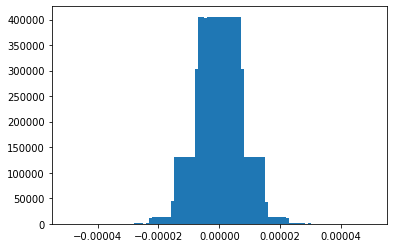

In [90]:
bb = plt.hist(diff.flatten(), range=(-.00005,.00005), bins=100)

In [98]:
data = fits.getdata('./MAST_flcs/jdxf09gqq_flc.fits', 1)
s = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
mask = (segmap > 0)
bkg = Background2D(data, box_size=box_size, filter_size=(10, 10), 
                   sigma_clip=s, bkg_estimator=bkg_estimator)


In [109]:
np.median(bkg.mesh_nmasked / (128*128) * 100)

3.4423828125

In [103]:
(4096*2048) / (128*128)

512.0

In [105]:
bkg.mesh_nmasked.shape[0] * bkg.mesh_nmasked.shape[1]

512

In [102]:
bkg.mesh_nmasked

array([[ 496,  545,  598,  484,  485,  416,  527,  457,  404,  303,  437,
         397,  377,  480,  449,  462,  432,  351,  787,  360,  455,  416,
         494,  466,  361,  371,  421,  443,  419,  524,  439,  363],
       [ 549,  370,  476,  489,  540,  449,  365,  384,  351,  419,  423,
         420,  524,  418,  346,  382,  344,  412,  371,  554,  464,  437,
         453,  513,  332,  449,  381,  482,  562,  419,  412,  428],
       [ 518,  620,  322,  535,  470,  563,  460,  383,  484,  475,  383,
         491,  457,  369,  473,  557,  412,  404,  459,  391,  487,  586,
         397,  447,  353,  370,  375,  403,  498,  483,  559,  352],
       [ 405,  552,  503,  415,  513,  427,  505,  514,  473,  421,  453,
         395,  384,  520,  443,  495,  484,  414,  386,  394,  397,  444,
         426,  551,  344,  465,  390,  421,  506,  442,  500,  653],
       [ 516,  587,  540,  487,  468,  467,  485,  517,  674,  450,  519,
         544,  412,  486,  464,  493,  442,  420,  442,  4

In [94]:
np.max(diff)

0.0029184171944507398

In [93]:
np.nanmedian(diff)

-1.842096253312775e-09

In [27]:
# Drizzle check

from drizzlepac import astrodrizzle as ad
import glob
from stsci.tools import teal
teal.unlearn('astrodrizzle')
import os

os.chdir('../test_feb2021_new_code/')

files = glob.glob('*_flc.fits')
ad.AstroDrizzle(files, driz_cr_corr=True, driz_combine=True, clean=True, build=True, driz_cr_snr='3.5 3.0')

os.chdir('../')

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 10:42:52.918 (03/02/2021)

==== Processing Step  Initialization  started at  10:42:52.921 (03/02/2021)

Preserving original of:  jdxfa9i0q_flc.fits as  OrIg_files/jdxfa9i0q_flc.fits
Preserving original of:  jdxfa9iaq_flc.fits as  OrIg_files/jdxfa9iaq_flc.fits
Preserving original of:  jdxfa9hoq_flc.fits as  OrIg_files/jdxfa9hoq_flc.fits
Preserving original of:  jdxfa9ikq_flc.

       EXT = 'SCI',2
             Data units type: COUNTS
             EXPTIME: 635.0 [s]
             Conversion factor (data->brightness):  0.6299212598425196

   *   Image: jdxfa9ieq_flc.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 635.0 [s]
             Conversion factor (data->brightness):  0.6299212598425196
       EXT = 'SCI',2
             Data units type: COUNTS
             EXPTIME: 635.0 [s]
             Conversion factor (data->brightness):  0.6299212598425196

   *   Image: jdxfa9inq_flc.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 635.0 [s]
             Conversion factor (data->brightness):  0.6299212598425196
       EXT = 'SCI',2
             Data units type: COUNTS
             EXPTIME: 635.0 [s]
             Conversion factor (data->brightness):  0.6299212598425196

   *   Image: jdxfa9hrq_flc.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 773.0 [s]
   

reference sky value for image 'jdxfa9ikq_flc.fits' is 62.061607360839844
reference sky value for image 'jdxfa9i7q_flc.fits' is 35.46918487548828
reference sky value for image 'jdxfa9isq_flc.fits' is 30.81996726989746
reference sky value for image 'jdxfa9ihq_flc.fits' is 9.928136825561523
reference sky value for image 'jdxfa9ieq_flc.fits' is 10.189067840576172
reference sky value for image 'jdxfa9inq_flc.fits' is 222.9523162841797
reference sky value for image 'jdxfa9hrq_flc.fits' is 12.313889503479004
reference sky value for image 'jdxfa9hxq_flc.fits' is 256.9866943359375
reference sky value for image 'jdxfa9iqq_flc.fits' is 43.55012512207031
Saving output median image to: 'final_med.fits'
==== Processing Step Create Median finished at 10:43:40.10 (03/02/2021)
==== Processing Step  Blot  started at  10:43:40.102 (03/02/2021)

    Blot: creating blotted image:  jdxfa9i0q_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: jdxfa9i0q_sci1_blt

CD2_1 CD2_2  : 4.649163469184382e-07  1.3881105408369651e-05  
NAXIS : 4216  4245
-Generating multi-extension output file:  final_drc.fits
Deleted all instances of WCS with key A in extensions [1]
Writing out to disk: final_drc.fits
==== Processing Step Final Drizzle finished at 10:45:21.116 (03/02/2021)

AstroDrizzle Version 3.1.6 is finished processing at 10:45:21.119 (03/02/2021).



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          6.1492 sec.
            Static Mask          4.3426 sec.
           Subtract Sky          10.5785 sec.
       Separate Drizzle          5.6230 sec.
          Create Median          20.4778 sec.
                   Blot          32.5691 sec.
                Driz_CR          12.3009 sec.
          Final Drizzle          56.1273 sec.
   ====================          ====================
                  Total          148

In [97]:
bkg.mesh_nmasked

AttributeError: 'numpy.ndarray' object has no attribute 'mesh_nmasked'

Text(0, 0.5, 'Number of Pixels')

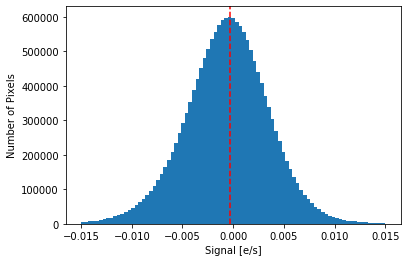

In [68]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


d = fits.getdata('./test_feb2021_new_code/final_drc.fits', 'SCI').flatten()
n,bins,patches = plt.hist(d, bins=85, range=(-.015,.015))

bin_centers = (bins[:-1] + bins[1:]) / 2
nmax = bin_centers[n==max(n)]

plt.axvline(np.nanmedian(nmax), color='red', ls='--')
#plt.yscale('log')
plt.xlabel('Signal [e/s]')
plt.ylabel('Number of Pixels')
#plt.title('New Visit A9 Drizzle')


Text(0, 0.5, 'Number of Pixels')

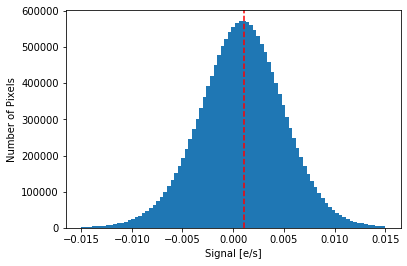

In [64]:
d = fits.getdata('./test_feb2021_orig_code/final_drc.fits', 'SCI').flatten()
n,bins,patches = plt.hist(d, bins=85, range=(-.015,.015))

bin_centers = (bins[:-1] + bins[1:]) / 2
nmax = bin_centers[n==max(n)]

plt.axvline(np.nanmedian(nmax), color='red', ls='--')
#plt.yscale('log')
plt.xlabel('Signal [e/s]')
plt.ylabel('Number of Pixels')
#plt.title('New Visit A9 Drizzle')

Text(0, 0.5, 'Number of Pixels')

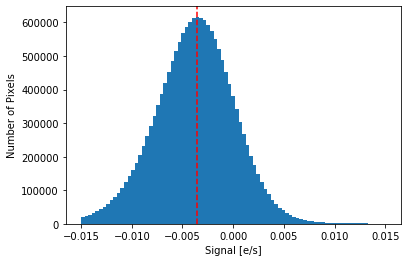

In [66]:
d = fits.getdata('./test_feb2021/final_drc.fits', 'SCI').flatten()
n,bins,patches = plt.hist(d, bins=85, range=(-.015,.015))

bin_centers = (bins[:-1] + bins[1:]) / 2
nmax = bin_centers[n==max(n)]

plt.axvline(np.nanmedian(nmax), color='red', ls='--')
#plt.yscale('log')
plt.xlabel('Signal [e/s]')
plt.ylabel('Number of Pixels')
#plt.title('Current Visit A9 Drizzle')

Text(0, 0.5, 'Number of Pixels')

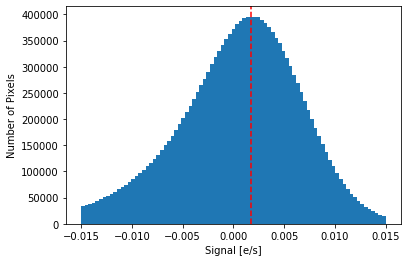

In [67]:
d = fits.getdata('./final_drc_old.fits', 'SCI').flatten()
n,bins,patches = plt.hist(d, bins=85, range=(-.015,.015))

bin_centers = (bins[:-1] + bins[1:]) / 2
nmax = bin_centers[n==max(n)]

plt.axvline(np.nanmedian(nmax), color='red', ls='--')
#plt.yscale('log')
plt.xlabel('Signal [e/s]')
plt.ylabel('Number of Pixels')
#plt.title('New Visit A9 Drizzle')

Text(0.5, 1.0, 'jdxfa9ihq_flc.fits')

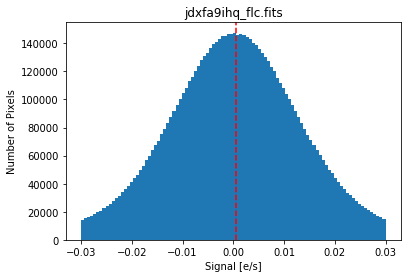

In [144]:
d = fits.getdata('./test_feb2021/jdxfa9ihq_flc.fits', 1).flatten()
t = fits.getheader('./test_feb2021/jdxfa9ihq_flc.fits', 'PRIMARY')['EXPTIME']
d = d/t
a = plt.hist(d, bins=100, range=(-.03,.03))
plt.axvline(np.nanmedian(d), color='red', ls='--')
plt.xlabel('Signal [e/s]')
plt.ylabel('Number of Pixels')
plt.title('jdxfa9ihq_flc.fits')

In [73]:
for f in glob.glob('./test_feb2021_new_code/*a9*flc.fits'):
    ff = f.replace('test_feb2021_new_code', '')
    print(os.path.basename(f))
    d = fits.getdata(f, 3)
    n = (len(d[d&4096!=0]) / (4096*2048)) * 100
    print('NEW', n)
    d = fits.getdata(f, 6)
    n = (len(d[d&4096!=0]) / (4096*2048)) * 100
    print('NEW', n)
    
    d = fits.getdata(ff, 3)
    n = (len(d[d&4096!=0]) / (4096*2048)) * 100
    print('MAST', n)
    d = fits.getdata(ff, 6)
    n = (len(d[d&4096!=0]) / (4096*2048)) * 100
    print('MAST', n)
    
    print('-------')

jdxfa9i0q_flc.fits
NEW 3.728342056274414
NEW 3.715646266937256
MAST 3.4206271171569824
MAST 3.701353073120117
-------
jdxfa9iaq_flc.fits
NEW 10.994625091552734
NEW 9.690380096435547
MAST 7.924890518188477
MAST 10.067999362945557
-------
jdxfa9hoq_flc.fits
NEW 12.279164791107178
NEW 10.882794857025146
MAST 8.943426609039307
MAST 11.329066753387451
-------
jdxfa9ikq_flc.fits
NEW 2.1877050399780273
NEW 2.088749408721924
MAST 2.096879482269287
MAST 2.1112680435180664
-------
jdxfa9i7q_flc.fits
NEW 4.853785037994385
NEW 4.5441508293151855
MAST 3.9365053176879883
MAST 4.640460014343262
-------
jdxfa9isq_flc.fits
NEW 4.141640663146973
NEW 3.9692044258117676
MAST 3.5384774208068848
MAST 4.021060466766357
-------
jdxfa9ihq_flc.fits
NEW 10.978353023529053
NEW 9.901797771453857
MAST 8.138704299926758
MAST 10.20503044128418
-------
jdxfa9ieq_flc.fits
NEW 11.41653060913086
NEW 10.38733720779419
MAST 8.711099624633789
MAST 10.708880424499512
-------
jdxfa9inq_flc.fits
NEW 1.3789057731628418
NEW 1.32

In [71]:
data.shape

(2048, 4096)

In [161]:
for f in glob.glob('./test_feb2021/*a9*flc.fits'):
    print(f)
    d = fits.getdata(f, 3)
    #t = fits.getheader(f, 0)['EXPTIME']
    n = (len(d[d&4096!=0]) / (4096*2048)) * 100
    print(np.nanmedian(n))

./test_feb2021/jdxfa9i0q_flc.fits
22.262871265411377
./test_feb2021/jdxfa9iaq_flc.fits
14.739930629730225
./test_feb2021/jdxfa9hoq_flc.fits
13.615155220031738
./test_feb2021/jdxfa9ikq_flc.fits
17.16151237487793
./test_feb2021/jdxfa9i7q_flc.fits
16.644775867462158
./test_feb2021/jdxfa9isq_flc.fits
13.75417709350586
./test_feb2021/jdxfa9ihq_flc.fits
10.982000827789307
./test_feb2021/jdxfa9ieq_flc.fits
11.699402332305908
./test_feb2021/jdxfa9inq_flc.fits
28.15157175064087
./test_feb2021/jdxfa9hrq_flc.fits
13.078510761260986
./test_feb2021/jdxfa9hxq_flc.fits
30.581271648406982
./test_feb2021/jdxfa9iqq_flc.fits
16.42019748687744


In [162]:
for f in glob.glob('./test_feb2021_new_code/*a9*flc.fits'):
    print(f)
    d = fits.getdata(f, 3)
    #t = fits.getheader(f, 0)['EXPTIME']
    n = (len(d[d&4096!=0]) / (4096*2048)) * 100
    print(np.nanmedian(n))

./test_feb2021_new_code/jdxfa9i0q_flc.fits
3.7476420402526855
./test_feb2021_new_code/jdxfa9iaq_flc.fits
11.153948307037354
./test_feb2021_new_code/jdxfa9hoq_flc.fits
12.427759170532227
./test_feb2021_new_code/jdxfa9ikq_flc.fits
2.2089481353759766
./test_feb2021_new_code/jdxfa9i7q_flc.fits
4.911541938781738
./test_feb2021_new_code/jdxfa9isq_flc.fits
4.180479049682617
./test_feb2021_new_code/jdxfa9ihq_flc.fits
11.049211025238037
./test_feb2021_new_code/jdxfa9ieq_flc.fits
11.513876914978027
./test_feb2021_new_code/jdxfa9inq_flc.fits
1.390695571899414
./test_feb2021_new_code/jdxfa9hrq_flc.fits
13.071560859680176
./test_feb2021_new_code/jdxfa9hxq_flc.fits
1.2973666191101074
./test_feb2021_new_code/jdxfa9iqq_flc.fits
4.049563407897949


In [163]:
for f in glob.glob('./*a9*flc.fits'):
    print(f)
    d = fits.getdata(f, 3)
    #t = fits.getheader(f, 0)['EXPTIME']
    n = (len(d[d&4096!=0]) / (4096*2048)) * 100
    print(np.nanmedian(n))

./jdxfa9i0q_flc.fits
3.4206271171569824
./jdxfa9iaq_flc.fits
7.924890518188477
./jdxfa9hoq_flc.fits
8.943426609039307
./jdxfa9ikq_flc.fits
2.096879482269287
./jdxfa9i7q_flc.fits
3.9365053176879883
./jdxfa9isq_flc.fits
3.5384774208068848
./jdxfa9ihq_flc.fits
8.138704299926758
./jdxfa9ieq_flc.fits
8.711099624633789
./jdxfa9inq_flc.fits
1.5570521354675293
./jdxfa9hrq_flc.fits
9.390771389007568
./jdxfa9hxq_flc.fits
1.4177441596984863
./jdxfa9iqq_flc.fits
3.700268268585205


In [165]:
for f in glob.glob('./*a9*flc.fits'):
    print(f)
    d = fits.getdata(f, 1)
    #t = fits.getheader(f, 0)['EXPTIME']
    #n = (len(d[d&4096!=0]) / (4096*2048)) * 100
    print(np.nanmedian(d))

./jdxfa9i0q_flc.fits
71.613525
./jdxfa9iaq_flc.fits
17.363825
./jdxfa9hoq_flc.fits
13.707466
./jdxfa9ikq_flc.fits
63.209267
./jdxfa9i7q_flc.fits
35.688866
./jdxfa9isq_flc.fits
30.954384
./jdxfa9ihq_flc.fits
9.823201
./jdxfa9ieq_flc.fits
10.132814
./jdxfa9inq_flc.fits
228.12245
./jdxfa9hrq_flc.fits
12.226781
./jdxfa9hxq_flc.fits
261.86084
./jdxfa9iqq_flc.fits
43.820576


In [147]:
for f in glob.glob('./MAST_flcs/*a9*flc.fits'):
    print(f)
    d = fits.getdata(f, 3)
    #t = fits.getheader(f, 0)['EXPTIME']
    n = (len(d[d&4096!=0]) / (4096*2048)) * 100
    print(np.nanmedian(n))

./MAST_flcs/jdxfa9i0q_flc.fits
2.117788791656494
./MAST_flcs/jdxfa9iaq_flc.fits
2.450680732727051
./MAST_flcs/jdxfa9hoq_flc.fits
2.644073963165283
./MAST_flcs/jdxfa9ikq_flc.fits
1.1105775833129883
./MAST_flcs/jdxfa9i7q_flc.fits
1.803910732269287
./MAST_flcs/jdxfa9isq_flc.fits
1.6469717025756836
./MAST_flcs/jdxfa9ihq_flc.fits
2.454686164855957
./MAST_flcs/jdxfa9ieq_flc.fits
2.855658531188965
./MAST_flcs/jdxfa9inq_flc.fits
1.1486172676086426
./MAST_flcs/jdxfa9hrq_flc.fits
2.5183558464050293
./MAST_flcs/jdxfa9hxq_flc.fits
1.0412335395812988
./MAST_flcs/jdxfa9iqq_flc.fits
2.223086357116699


In [146]:
for f in glob.glob('./MAST_flcs/*a9*flc.fits'):
    print(f)
    d = fits.getdata(f, 3)
    #t = fits.getheader(f, 0)['EXPTIME']
    n = len(d[d&4096!=0])
    print(np.nanmedian(n))

./MAST_flcs/jdxfa9i0q_flc.fits
177653.0
./MAST_flcs/jdxfa9iaq_flc.fits
205578.0
./MAST_flcs/jdxfa9hoq_flc.fits
221801.0
./MAST_flcs/jdxfa9ikq_flc.fits
93162.0
./MAST_flcs/jdxfa9i7q_flc.fits
151323.0
./MAST_flcs/jdxfa9isq_flc.fits
138158.0
./MAST_flcs/jdxfa9ihq_flc.fits
205914.0
./MAST_flcs/jdxfa9ieq_flc.fits
239550.0
./MAST_flcs/jdxfa9inq_flc.fits
96353.0
./MAST_flcs/jdxfa9hrq_flc.fits
211255.0
./MAST_flcs/jdxfa9hxq_flc.fits
87345.0
./MAST_flcs/jdxfa9iqq_flc.fits
186486.0


In [66]:
(177653 / (2048*4096)) * 100

2.117788791656494

In [62]:
d.shape

(2048, 4096)

In [60]:
d

array([[4096,    0,    0, ...,    0,    0,    0],
       [4096,    0,    0, ...,    0,    0,    0],
       [4096, 4096, 4096, ...,    0,    0,    0],
       ...,
       [4096,    0,    0, ..., 4096,    0,    0],
       [4096, 4096,    0, ..., 4096, 4096,    0],
       [4096, 4096, 4096, ..., 4096, 4096, 4096]], dtype=uint16)

In [19]:
fits.getheader('./test_feb2021/final_drc.fits', 'SCI')['BUNIT']

'ELECTRONS/S'

In [27]:
fits.getheader('./test_feb2021/jdxfa9hoq_flc.fits', 'SCI')['BUNIT'],\
fits.getheader('./test_feb2021/jdxfa9hoq_flc.fits', 'PRIMARY')['EXPTIME']

('ELECTRONS', 773.0)

In [50]:
f

'./test_feb2021/jdxfa9iqq_flc.fits'

In [25]:
2048/128

16.0

In [20]:
np.nanmedian(d)

-0.0036967215

In [ ]:
d = fits.getdata('./test_feb2021/final_drc.fits', 'SCI').flatten()
